In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline
%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/android-app-market-on-google-play/datasets/apps.csv
/kaggle/input/android-app-market-on-google-play/datasets/user_reviews.csv


# **Unveiling the Android App Market: Analyzing Google**

**1. Data Preparation**

Cleaning and Correcting data for accuracy. The first thing to do when you get a new dataset is take a look at some of it. This lets you see that it all read in correctly and gives an idea of what's going on with the data. In this case, let's see if there are any missing values, which will be reprsented with NaN or None.




In [57]:
#Clean and correct data types for accuracy.
apps_data = pd.read_csv("/kaggle/input/android-app-market-on-google-play/datasets/apps.csv")
user_rev = pd.read_csv("/kaggle/input/android-app-market-on-google-play/datasets/user_reviews.csv")
np.random.seed(0) 


In [58]:
#missing data on apps dataset
apps_data.sample(5)

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2279,2913,Camera FV-5,PHOTOGRAPHY,3.8,16320,NaN,"100,000+",Paid,$3.95,Everyone,Photography,"November 10, 2017",Varies with device,Varies with device
5173,6169,BG Metro - Red voznje,TRAVEL_AND_LOCAL,4.8,89,NaN,"1,000+",Free,0,Everyone,Travel & Local,"February 21, 2017",Varies with device,Varies with device
3849,4779,X Back - Icon Pack,PERSONALIZATION,4.5,56,26.0,"10,000+",Paid,$0.99,Everyone,Personalization,"June 29, 2018",1.6.2,4.1 and up
2265,2893,Camera ZOOM FX - FREE,PHOTOGRAPHY,4.0,88860,6.1,"5,000,000+",Free,0,Everyone,Photography,"April 6, 2017",6.2.9,2.3 and up
2636,3365,ZenUI Launcher,PERSONALIZATION,4.7,1141545,15.0,"50,000,000+",Free,0,Everyone,Personalization,"July 31, 2018",Varies with device,Varies with device


In [59]:
# get the number of missing data points per column
missing_values_count = apps_data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Unnamed: 0           0
App                  0
Category             0
Rating            1463
Reviews              0
Size              1227
Installs             0
Type                 0
Price                0
Content Rating       0
dtype: int64

In [60]:
subset_apps_data = apps_data.loc[:, 'App':'Content Rating'].head()
subset_apps_data

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone


In [61]:
# replace all NA's with 0
subset_apps_data.fillna(0)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone


In [62]:
#missing data on user reviews dataset
user_rev.sample(5)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
4407,Adult Dating - AdultFinder,NaN,NaN,NaN,NaN
12646,Barbie Magical Fashion,NaN,NaN,NaN,NaN
50526,Fuelio: Gas log & costs,Hi developer possible add consumption unit lik...,Neutral,0.0,1.0
3535,AT&T Visual Voicemail,NaN,NaN,NaN,NaN
20878,Calculator Plus Free,NaN,NaN,NaN,NaN


In [63]:
# get the number of missing data points per column
missing_values_count = user_rev.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:10]

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [64]:
# remove all columns with at least one missing value
user_rev.dropna()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.250000,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.400000,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.000000,0.300000
5,10 Best Foods for You,Best way,Positive,1.000000,0.300000
...,...,...,...,...,...
64222,Housing-Real Estate & Property,Most ads older many agents ..not much owner po...,Positive,0.173333,0.486667
64223,Housing-Real Estate & Property,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000,0.447222
64226,Housing-Real Estate & Property,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500,0.250000
64227,Housing-Real Estate & Property,I property business got link SMS happy perform...,Positive,0.800000,1.000000


In [65]:
# just how much data did we lose?
print("Columns in original dataset: %d \n" % user_rev.shape[0])
print("Columns with na's dropped: %d" % user_rev.shape[1])

Columns in original dataset: 64295 

Columns with na's dropped: 5


**2. Category Exploration**:

Investigate app distribution across categories. Exploring data through train setting.

In [134]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from tqdm.autonotebook import tqdm
import string

%matplotlib inline

In [135]:
# reading csv files and train & test file paths
train_apps_data = pd.read_csv('/kaggle/input/android-app-market-on-google-play/datasets/apps.csv')
sample_user_rev = pd.read_csv('/kaggle/input/android-app-market-on-google-play/datasets/user_reviews.csv')
train_files_path = '/kaggle/input/android-app-market-on-google-play/train'
test_files_path = '/kaggle/input/android-app-market-on-google-play/test'

Taking a look at data stats

In [136]:
print('Number of reviews: {}'.format(len(train_apps_data)))
print('Rating: {:.4}%'.format(train_apps_data.Rating.mean()))

Number of reviews: 9659
Rating: 4.173%


The result shows that in the training set we have a total of just 7021 reviews and a mean of 4.16% of ratings..

In [69]:
#Display the first few rows of our data
train_apps_data.head(6)

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1,2.3 and up


In [70]:
[print(f"{col}:{len(train_apps_data[col].unique())}") for col in train_apps_data.columns]   #finding unique values in each column

Unnamed: 0:9659
App:9659
Category:33
Rating:40
Reviews:5330
Size:192
Installs:21
Type:2
Price:92
Content Rating:6
Genres:118
Last Updated:1377
Current Ver:2770
Android Ver:34


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [71]:
print( len(train_apps_data['Category'].unique()) , "categories")

print("\n", train_apps_data['Category'].unique())

33 categories

 ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']


**Count of Apps in each Category**

Text(0.5, 1.0, 'Count of app in each category')

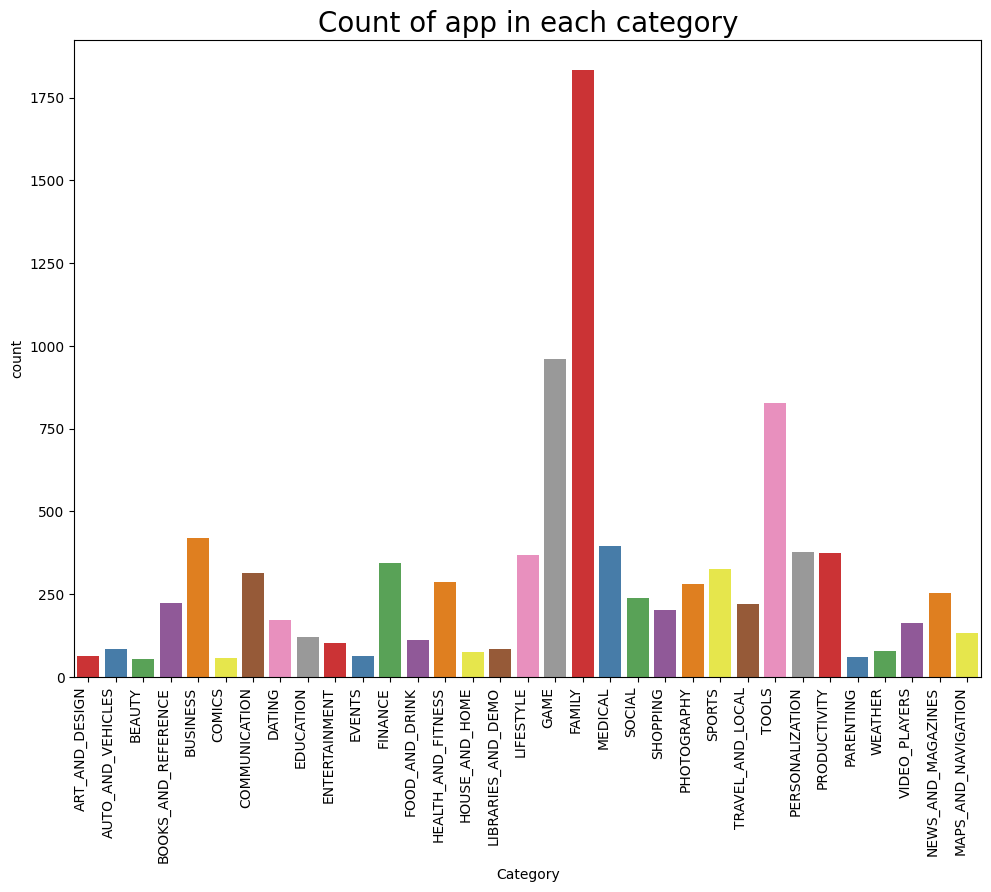

In [72]:
g = sns.countplot(x="Category",data=train_apps_data, palette = "Set1")
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Count of app in each category',size = 20)

Results show that Family is the leading category, followed by game.

**3. Metrics Analysis**

* Examine app ratings
* size,
* popularity,
* pricing trends.



**Ratings**

In [73]:
train_apps_data.columns

Index(['Unnamed: 0', 'App', 'Category', 'Rating', 'Reviews', 'Size',
       'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated',
       'Current Ver', 'Android Ver'],
      dtype='object')

In [74]:
train_apps_data['Rating'].describe()

count    8196.000000
mean        4.173243
std         0.536625
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

In [75]:
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams

Text(0.5, 1.0, 'Distribution of Rating')

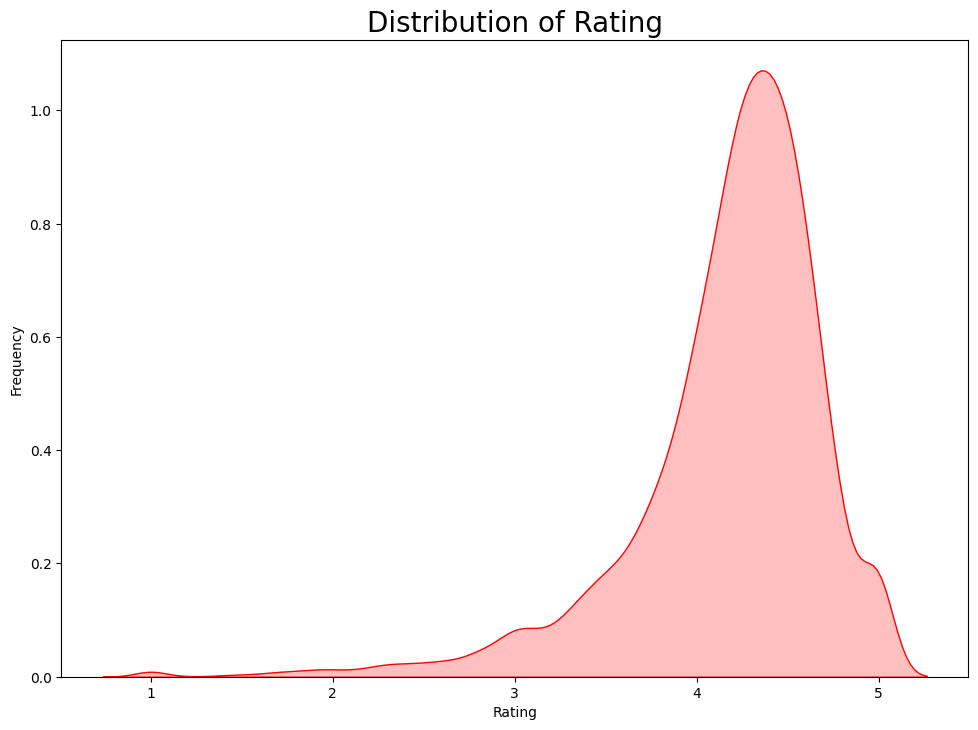

In [76]:

rcParams['figure.figsize'] = 11.7,8.27
g = sns.kdeplot(train_apps_data.Rating, color="Red", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

Average rating of applications is around 4-5 of which is very high

**Size**

In [77]:
#size
train_apps_data['Size'].head()

0    19.0
1    14.0
2     8.7
3    25.0
4     2.8
Name: Size, dtype: float64

In [78]:
train_apps_data['Size'].unique()

array([ 19. ,  14. ,   8.7,  25. ,   2.8,   5.6,  29. ,  33. ,   3.1,
        28. ,  12. ,  20. ,  21. ,  37. ,   2.7,   5.5,  17. ,  39. ,
        31. ,   4.2,   7. ,  23. ,   6. ,   6.1,   4.6,   9.2,   5.2,
        11. ,  24. ,   nan,   9.4,  15. ,  10. ,   1.2,  26. ,   8. ,
         7.9,  56. ,  57. ,  35. ,  54. ,   0.2,   3.6,   5.7,   8.6,
         2.4,  27. ,   2.5,  16. ,   3.4,   8.9,   3.9,   2.9,  38. ,
        32. ,   5.4,  18. ,   1.1,   2.2,   4.5,   9.8,  52. ,   9. ,
         6.7,  30. ,   2.6,   7.1,   3.7,  22. ,   7.4,   6.4,   3.2,
         8.2,   9.9,   4.9,   9.5,   5. ,   5.9,  13. ,  73. ,   6.8,
         3.5,   4. ,   2.3,   7.2,   2.1,  42. ,   7.3,   9.1,  55. ,
         0. ,   6.5,   1.5,   7.5,  51. ,  41. ,  48. ,   8.5,  46. ,
         8.3,   4.3,   4.7,   3.3,  40. ,   7.8,   8.8,   6.6,   5.1,
        61. ,  66. ,   0.1,   8.4,  44. ,   0.7,   1.6,   6.2,  53. ,
         1.4,   3. ,   5.8,   3.8,   9.6,  45. ,  63. ,  49. ,  77. ,
         4.4,   4.8,

In [79]:
#fill "nan" with mean of size in each category
train_apps_data['Size'].fillna(train_apps_data.groupby('Category')['Size'].transform('mean'),inplace = True)

<Figure size 1000x1000 with 0 Axes>

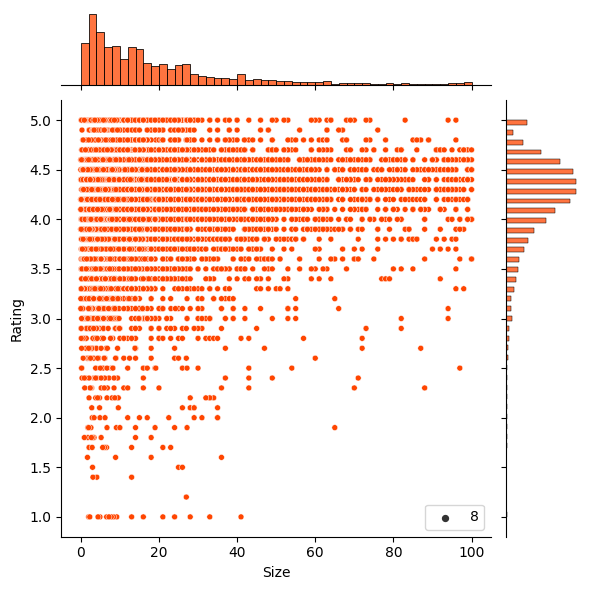

In [80]:
plt.figure(figsize = (10,10))
g = sns.jointplot(x="Size", y="Rating",color = 'orangered', data=train_apps_data, size = 8);

**Pricing**

In [81]:
train_apps_data['Price'].head()

0    0
1    0
2    0
3    0
4    0
Name: Price, dtype: object

In [82]:
train_apps_data.Price.unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

The results show that we have an object type, in format of dollar sign.

In [83]:
train_apps_data['Price'].value_counts().head(50)

Price
0          8903
$0.99       145
$2.99       124
$1.99        73
$4.99        70
$3.99        57
$1.49        46
$5.99        26
$2.49        25
$9.99        19
$399.99      12
$6.99        11
$14.99        9
$4.49         9
$7.99         7
$3.49         7
$8.99         5
$19.99        5
$29.99        5
$6.49         5
$5.49         5
$12.99        4
$1.00         3
$11.99        3
$24.99        3
$2.00         3
$17.99        2
$13.99        2
$8.49         2
$1.70         2
$39.99        2
$10.99        2
$7.49         2
$16.99        2
$10.00        2
$3.08         1
$2.59         1
$4.80         1
$1.96         1
$4.29         1
$154.99       1
$19.40        1
$3.90         1
$4.59         1
$1.20         1
$15.46        1
$3.04         1
$46.99        1
$2.60         1
$89.99        1
Name: count, dtype: int64

In [84]:
train_apps_data['Price'].describe()

count     9659
unique      92
top          0
freq      8903
Name: Price, dtype: object

Average of price is around 1,10.The most expensive app is 400 dollars.

**Applications Popularity according to Reviews**

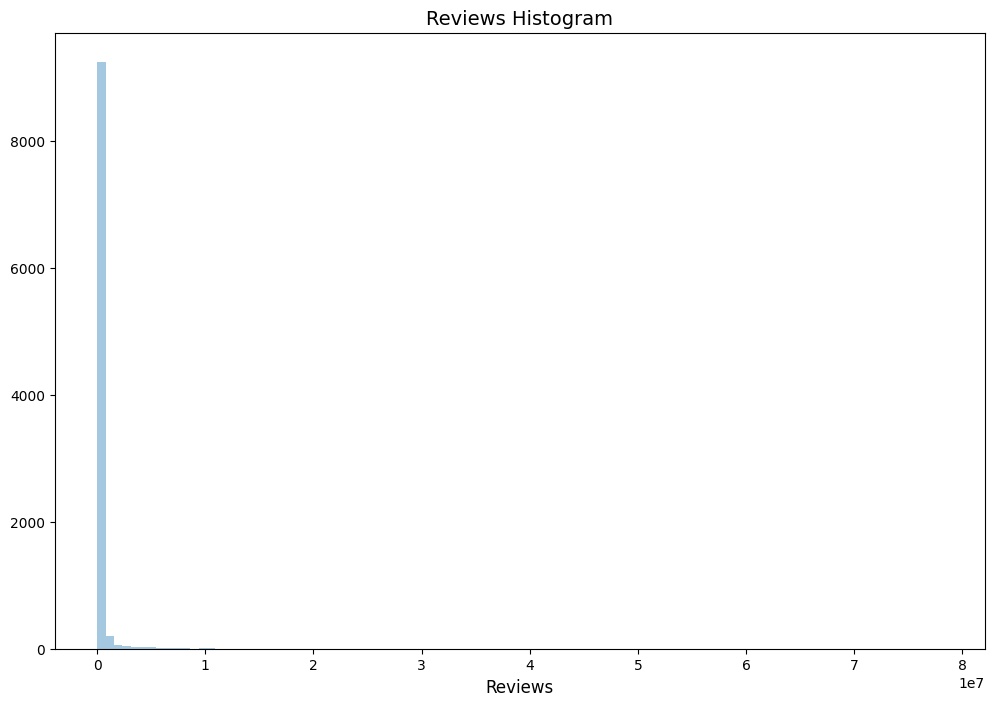

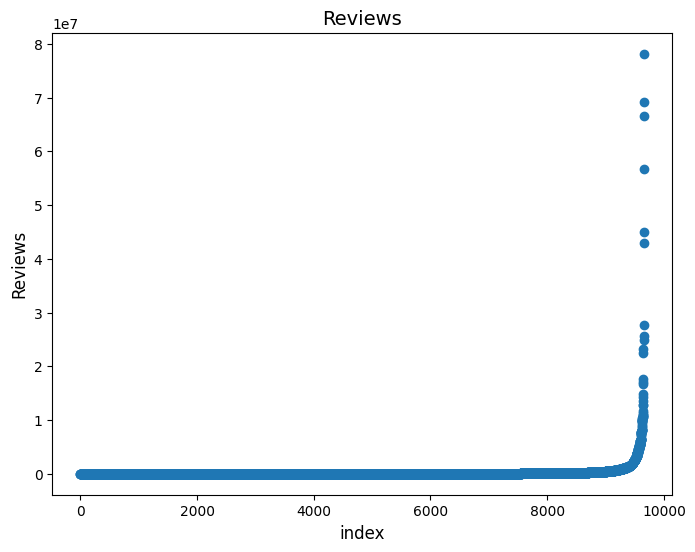

In [85]:
plt.figure(figsize=(12,8))
sns.distplot(train_apps_data["Reviews"].values, bins=100, kde=False)
plt.xlabel('Reviews', fontsize=12)
plt.title("Reviews Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(train_apps_data.shape[0]), np.sort(train_apps_data['Reviews'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Reviews', fontsize=12)
plt.title("Reviews", fontsize=14)
plt.show()


**4. Sentiment Analysis**

Assessing user sentiments through reviews. Lets look at the distribution of reviews in the train set

In [86]:
#Checking the number of rows and columns in our data
shape= sample_user_rev.shape
print("Number of rows:", shape[0])
print("Number of columns:", shape[1])

Number of rows: 64295
Number of columns: 5


In [87]:
sample_user_rev.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [88]:
sample_user_rev.tail()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64294,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [89]:
sample_user_rev.info()
sample_user_rev.nunique()
sample_user_rev.isna().sum()
print("Percentage null or na values in df")
((sample_user_rev.isnull() | sample_user_rev.isna()).sum() * 100 / sample_user_rev.index.size).round(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB
Percentage null or na values in df


App                        0.00
Translated_Review         41.79
Sentiment                 41.78
Sentiment_Polarity        41.78
Sentiment_Subjectivity    41.78
dtype: float64

Text(0.5, 1.0, 'Count of Type of Sentiment')

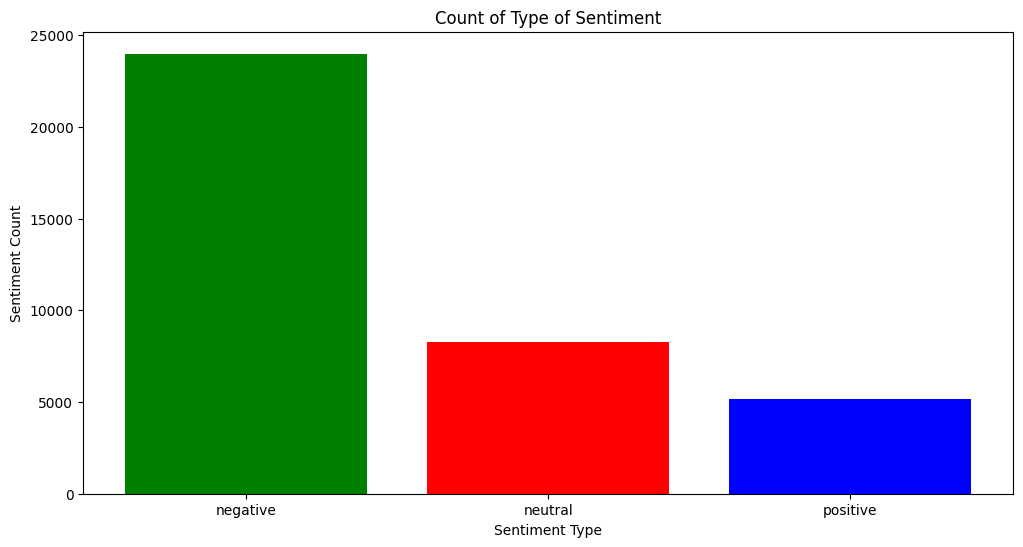

In [90]:

counter = sample_user_rev.Sentiment.value_counts()
index = [1,2,3]
plt.figure(1,figsize=(12,6))
plt.bar(index,counter,color=['green','red','blue'])
plt.xticks(index,['negative','neutral','positive'],rotation=0)
plt.xlabel('Sentiment Type')
plt.ylabel('Sentiment Count')
plt.title('Count of Type of Sentiment')

**App Sentiments for each Application**

Firstly, check how many apps we have

In [91]:
sample_user_rev['App'].unique()

array(['10 Best Foods for You', '104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室',
       '11st', ..., 'Hotwire Hotel & Car Rental App',
       'Housing-Real Estate & Property', 'Houzz Interior Design Ideas'],
      dtype=object)

Total number of translated reviews for each app 
  App
Bowmasters                                     312
Angry Birds Classic                            273
Helix Jump                                     273
Calorie Counter - MyFitnessPal                 255
Duolingo: Learn Languages Free                 240
                                              ... 
Glow Hockey                                      0
Glowing Flowers Live Wallpaper                   0
Cute wallpapers & kawaii backgrounds images      0
Cute Pet Puppies                                 0
Houzz Interior Design Ideas                      0
Name: Sentiment, Length: 1074, dtype: int64


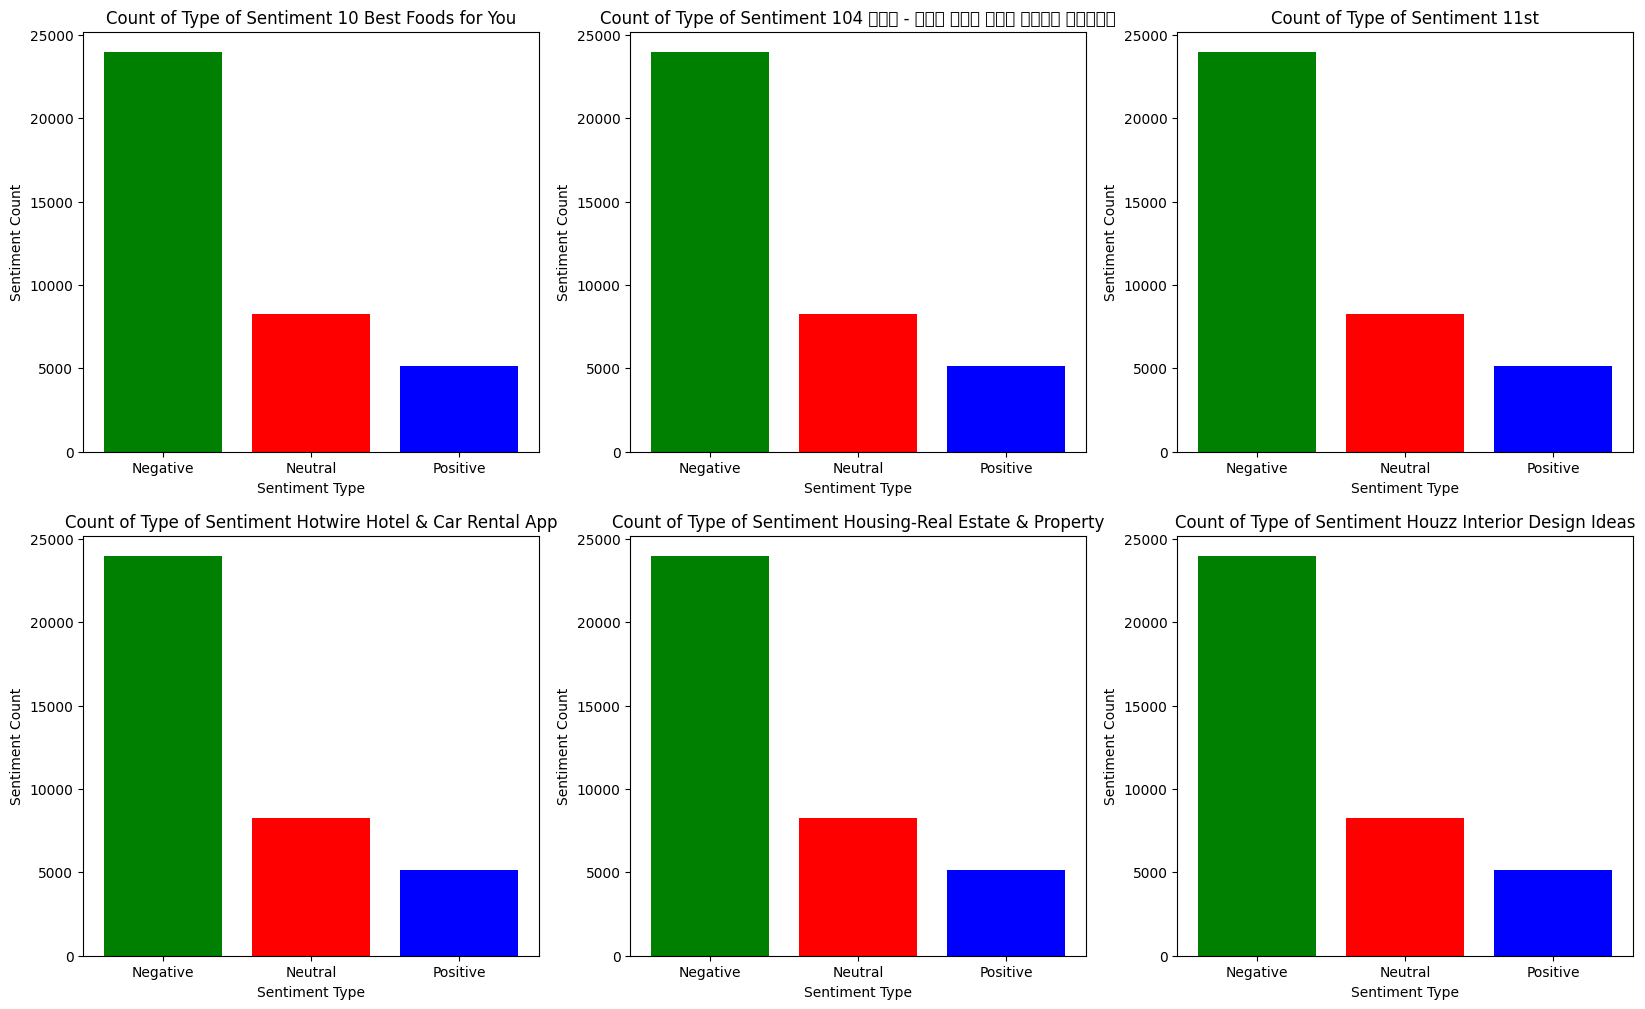

In [92]:
print("Total number of translated reviews for each app \n ",sample_user_rev.groupby('App')['Sentiment'].count().sort_values(ascending=False))
App = ['10 Best Foods for You', '104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室',
       '11st','Hotwire Hotel & Car Rental App',
       'Housing-Real Estate & Property', 'Houzz Interior Design Ideas']
plt.figure(1,figsize=(20, 12))
for i in App:
    indices= App.index(i)
    plt.subplot(2,3,indices+1)
    new_df=sample_user_rev[sample_user_rev['App']==i]
    count=new_df['Sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(index,counter,color=['green','red','blue'])
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment Type')
    plt.title('Count of Type of Sentiment '+i)

The results shows that people are not having pleasant application experiences.

**5. Interactive Visualization**

Utilize code for compelling visualizations.

In [93]:
train_apps_data['Reviews'].head()

0       159
1       967
2     87510
3    215644
4       967
Name: Reviews, dtype: int64

In [94]:
# convert reviews data to int

train_apps_data['Reviews'] = train_apps_data['Reviews'].apply(lambda x: int(x))

In [95]:
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams

Text(0.5, 1.0, 'Distribution of Reveiw')

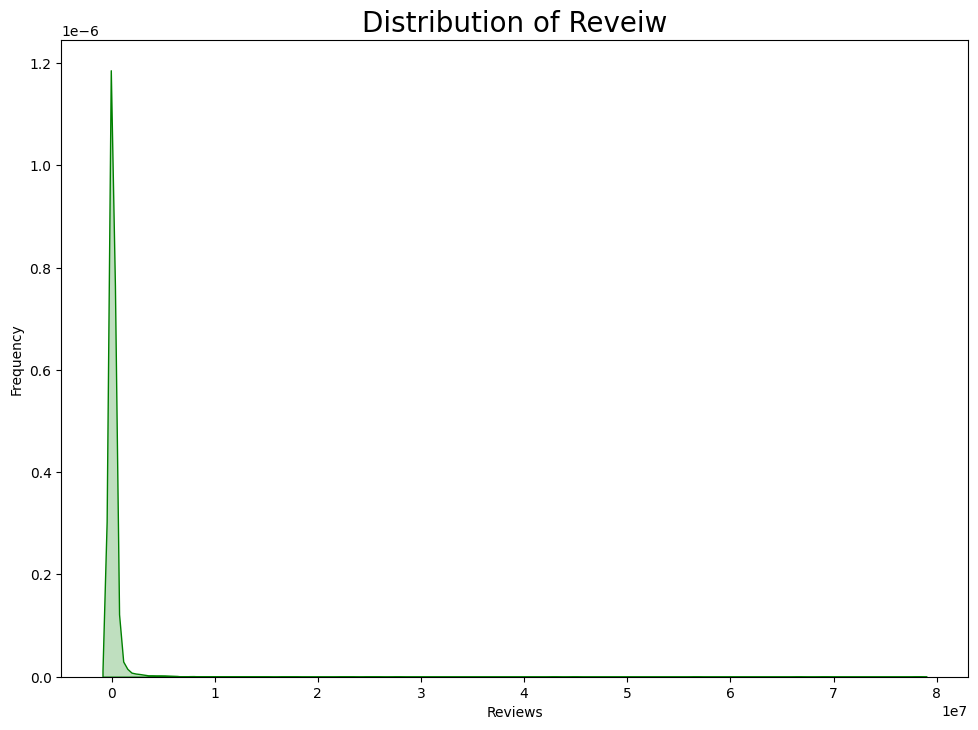

In [96]:
# rating distibution 
rcParams['figure.figsize'] = 11.7,8.27
g = sns.kdeplot(train_apps_data.Reviews, color="Green", shade = True)
g.set_xlabel("Reviews")
g.set_ylabel("Frequency")
plt.title('Distribution of Reveiw',size = 20)

In [97]:
train_apps_data[train_apps_data.Reviews > 5000000].head()

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
299,335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,11.308264,"1,000,000,000+",Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
300,336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,11.308264,"1,000,000,000+",Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
302,338,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995,11.308264,"1,000,000,000+",Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
306,342,Viber Messenger,COMMUNICATION,4.3,11334799,11.308264,"500,000,000+",Free,0,Everyone,Communication,"July 18, 2018",Varies with device,Varies with device
315,351,Opera Mini - fast web browser,COMMUNICATION,4.5,5149854,11.308264,"100,000,000+",Free,0,Everyone,Communication,"July 19, 2018",Varies with device,Varies with device


<Figure size 1000x1000 with 0 Axes>

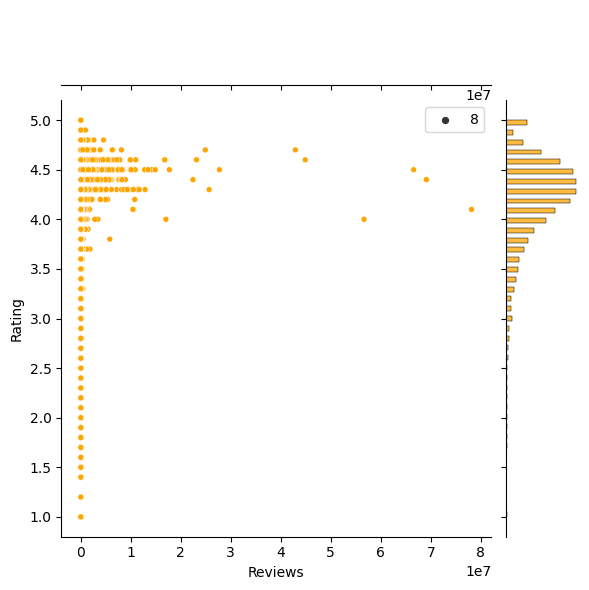

In [98]:
plt.figure(figsize = (10,10))
g = sns.jointplot(x="Reviews", y="Rating",color = 'orange', data = train_apps_data,size = 8);

Results shows that the applications are getting good reviews and ratings

**How pricing is affecting the rating**

In [99]:
train_apps_data=train_apps_data.dropna()
train_apps_data.shape
train_apps_data.head(10)

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1,2.3 and up
6,6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19.0,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29.0,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33.0,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


In [100]:

train_apps_data[['Price', 'Rating']].groupby(['Price'], as_index=False).mean()

,Price,Rating
0,$0.99,4.300971
1,$1.00,4.450000
2,$1.20,4.200000
3,$1.29,4.100000
4,$1.49,4.190000
...,...,...
68,$8.49,3.700000
69,$8.99,3.725000
70,$9.00,4.200000
71,$9.99,4.192857


In [158]:
train_apps_data.loc[ train_apps_data['Price'] == 0, 'PriceType'] = '0 Free'
train_apps_data.loc[(train_apps_data['Price'] > 0) & (train_apps_data['Price'] <= 0.99), 'PriceType'] = '1 cheap'
train_apps_data.loc[(train_apps_data['Price'] > 0.99) & (train_apps_data['Price'] <= 2.99), 'PriceType']   = '2 not cheap'
train_apps_data.loc[(train_apps_data['Price'] > 2.99) & (train_apps_data['Price'] <= 4.99), 'PriceType']   = '3 normal'
train_apps_data.loc[(train_apps_data['Price'] > 4.99) & (train_apps_data['Price'] <= 14.99), 'PriceType']   = '4 expensive'
train_apps_data.loc[(train_apps_data['Price'] > 14.99) & (train_apps_data['Price'] <= 29.99), 'PriceType']   = '5 too expensive'
train_apps_data.loc[(train_apps_data['Price'] > 29.99), 'PriceType']  = '6 Most expensive'

TypeError: '>' not supported between instances of 'str' and 'int'

In [154]:
train_apps_data[['PriceType', 'Rating']].groupby(['PriceType'], as_index=False).mean()

,PriceType,Rating


In [160]:
#Ratings vs Prices
g = sns.catplot(x="PriceType",y="Rating",data=train_apps_data, kind="boxen", height = 15 ,palette = "Pastel1")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Rating")
plt.title('Boxen plot Rating VS PriceType',size = 20)

ValueError: min() arg is an empty sequence

Results show that the price does not have much effect on rating,but if the application is most expensive it may result to lower rating

**6. Skill enahancement**

The best way to nderstand data visualization is to consider the following:

* **Learn Fundamental Principles**

Start by understanding the fundamental principles of data visualization, including concepts like encoding, perception, color theory, and visual hierarchy. Knowing the mentioned basics will help you create effective visualizations that accurately communicate your data.

* **Data Preparation Skills**

Learn how to prepare your data for visualization effectively. This includes data cleaning, transformation, and aggregation to ensure that your visualizations accurately represent the underlying data.

* **Understand your Visualization Tools better** 

Gain proficiency in popular data visualization tools and libraries like Matplotlib, Seaborn, Plotly, ggplot2 (for R), Tableau, Power BI, and D3.js. These tools offer different levels of flexibility and complexity, so it's beneficial to explore multiple options.

* **Know which Plots and Custom sytles to choose**

The best way to tell a story is to know how best to tell it. Familiarize yourself with various types of visualizations such as bar charts, line charts, scatter plots, histograms, heatmaps, and more. Each type has its strengths and weaknesses, and knowing when to use each one will make your visualizations more impactful.Understand the diffent types of chart types namely: Trends, Relationships and Distribution

**Trends** - A trend is defined as a pattern of change.
* sns.lineplot - Line charts are best to show trends over a period of time, and multiple lines can be used to show trends in more than one group.

**Relationship** - There are many different chart types that you can use to understand relationships between variables in your data.
* sns.barplot - Bar charts are useful for comparing quantities corresponding to different groups.
* sns.heatmap - Heatmaps can be used to find color-coded patterns in tables of numbers.
* sns.scatterplot - Scatter plots show the relationship between two continuous variables; if color-coded, we can also show the relationship with a third categorical variable.
* sns.regplot - Including a regression line in the scatter plot makes it easier to see any linear relationship between two variables.
* sns.lmplot - This command is useful for drawing multiple regression lines, if the scatter plot contains multiple, color-coded groups.
* sns.swarmplot - Categorical scatter plots show the relationship between a continuous variable and a categorical variable.

**Distribution** - We visualize distributions to show the possible values that we can expect to see in a variable, along with how likely they are.
* sns.histplot - Histograms show the distribution of a single numerical variable.
* sns.kdeplot - KDE plots (or 2D KDE plots) show an estimated, smooth distribution of a single numerical variable (or two numerical variables).
* sns.jointplot - This command is useful for simultaneously displaying a 2D KDE plot with the corresponding KDE plots for each individual variable.